# RENT PROPERTY ANALYSIS

## 1. Data Preprocessing 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import re

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read Data
house = pd.read_csv('../data/curated/merge_data_v2.csv')

### 1.1 Price extraction
Re-extract price from 'price' column, remove 'rent' as values are not correctly extracted.

In [3]:
# extract pattern 
p='([\d]{1,}[,][\d]{2,}|[\d]{2,4})'
house['rent price'] = house.price.str.extract(p) 

# change it to float
house['rent price'] = house['rent price'].str.replace(',', "")
house['rent price'] = house['rent price'].astype(float)


In [4]:
# checking rent price's distribution
house['rent price'].describe()

count    107521.000000
mean        832.235135
std        7927.466968
min           2.000000
25%         370.000000
50%         430.000000
75%         550.000000
max      800000.000000
Name: rent price, dtype: float64

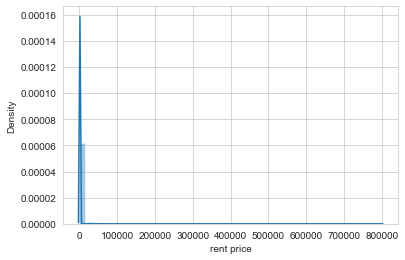

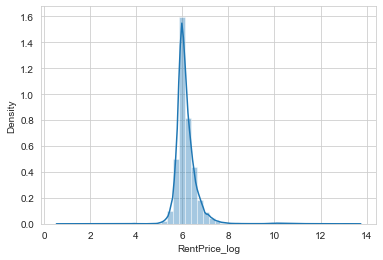

In [5]:
## check if we need to log the rental price as the price might be skewed
import seaborn as sns 
import matplotlib 
import matplotlib.pyplot as plt

x = house["rent price"]
sns.set_style('whitegrid')
sns.distplot(x)
plt.show()

house['RentPrice_log'] = np.log(house["rent price"])
x = house['RentPrice_log']
sns.distplot(x)
plt.show()

### 1.2 Rooms
Remove outliers for below:
 - bedroom 
 - bathroom 
 - carspace

In [6]:
# 1.2.1 check bedrooms
newdf = house
newdf['bathrooms'].value_counts().sort_values(ascending=False)

1.0     61815
2.0     46109
3.0      4048
0.0      2484
4.0       416
5.0        62
6.0        14
8.0         6
12.0        3
25.0        1
9.0         1
32.0        1
Name: bathrooms, dtype: int64

In [7]:
Q1 = newdf['bedrooms'].quantile(0.25)
Q3 = newdf['bedrooms'].quantile(0.75)
IQR = Q3-Q1
newdf = newdf[(newdf['bedrooms'] > (Q1 - 3*IQR)) & (newdf['bedrooms'] < (Q3 + 3*IQR))]

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb2379b2430>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb2379b29d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb2379b2160>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb2379b2f70>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb2379c1280>],
 'means': []}

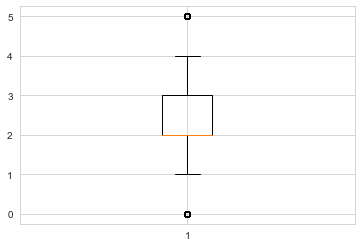

In [8]:
plt.boxplot(newdf['bedrooms'])

In [9]:
# 1.2.2 check bathroom
newdf['bathrooms'].value_counts().sort_values(ascending=False)

1.0     61809
2.0     46019
3.0      3947
0.0      2484
4.0       367
5.0        51
8.0         5
6.0         4
12.0        3
25.0        1
32.0        1
Name: bathrooms, dtype: int64

In [10]:
Q1 = newdf['bathrooms'].quantile(0.25)
Q3 = newdf['bathrooms'].quantile(0.75)
IQR = Q3-Q1
newdf = newdf[(newdf['bathrooms'] > (Q1 - 3*IQR)) & (newdf['bathrooms'] < (Q3 + 3*IQR))]

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb236fa1580>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb236fa1b20>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb236fa1220>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb236faf100>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb236faf3d0>],
 'means': []}

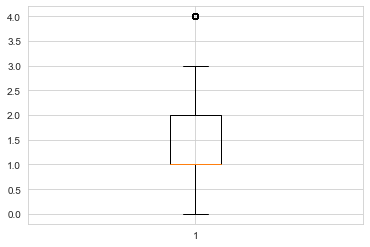

In [11]:
plt.boxplot(newdf['bathrooms'])

In [12]:
# 1.2.3 check carspace
newdf['carspaces'].value_counts().sort_values(ascending=False)

1.0      50172
2.0      35086
0.0      23224
3.0       2863
4.0       2351
5.0        331
6.0        316
8.0         77
7.0         61
10.0        38
15.0        13
9.0         13
12.0        11
20.0         9
16.0         7
14.0         7
11.0         6
24.0         4
13.0         4
23.0         4
18.0         3
30.0         3
85.0         3
36.0         2
50.0         2
17.0         2
22.0         2
76.0         1
26.0         1
31.0         1
56.0         1
67.0         1
200.0        1
130.0        1
109.0        1
33.0         1
28.0         1
38.0         1
32.0         1
Name: carspaces, dtype: int64

In [13]:
Q1 = newdf['carspaces'].quantile(0.25)
Q3 = newdf['carspaces'].quantile(0.75)
IQR = Q3-Q1
newdf = newdf[(newdf['carspaces'] > (Q1 - 3*IQR)) & (newdf['carspaces'] < (Q3 + 3*IQR))]

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb236c15a00>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb236c15fa0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb236c15730>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb236d9b580>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb236d9b850>],
 'means': []}

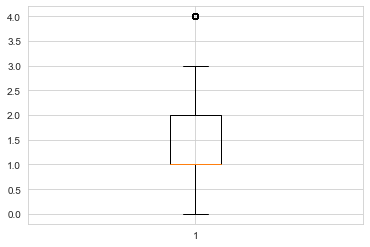

In [14]:
plt.boxplot(newdf['carspaces'])

### 1.3 Bond
Make bond to categorical data, where property has bond it will be 1 else 0.

In [15]:
# drop unused columns
newdf = newdf.drop(['Unnamed: 0','price','rent','geometry', 'geoLocation','index_right'], axis=1)

# assign values to has_bond
newdf = newdf.assign(has_bond=np.where(newdf.bond.isnull(), 0, 1))
newdf = newdf.drop(['bond'], axis=1)
# newdf.head(3)

### 1.4 Listing duration
Listing duration are the period the property been advertised on the site.

In [16]:
newdf["dateListed"] = pd.to_datetime(newdf["dateListed"])
newdf["dateUpdated"] = pd.to_datetime(newdf["dateUpdated"])
newdf['list_duration']=(newdf['dateUpdated']- newdf['dateListed']).dt.days

newdf = newdf.drop(['dateUpdated','dateListed'], axis=1)

# newdf.head(3)

### 1.5 Property Type
Since there are overlapping property for single property, the best way is to make a few categories to classify them. For each property, if it contain certain keywords we specify that is under a category, then 1 will be assigned to the property under that category. 

In [17]:
# house, unit/apartment, others 

newdf['ishouse'] = newdf['propertyTypes'].str.contains("house|townhouse|newHouseLand|villa")

newdf['isapartment'] = newdf['propertyTypes'].str.contains("Unit|blockOfUnits|newApartments|penthouse")

newdf['isother'] = ~(newdf['isapartment'])& ~(newdf['ishouse'])

newdf = newdf.drop(['propertyTypes'], axis=1)

# newdf[newdf['isother'] == True]

## 2. Missing values 
Process to handle missing values in the dataset.

In [18]:
missing = newdf.isnull().sum()/len(newdf['index'])*100
missing[missing>0]

landAreaSqm                              93.370039
distance of the closest bus stop          1.636821
distance of the closest train stop       54.254327
distance of the closest tram stop        47.270792
distance of the closest vline stop       59.763756
distance of the closest school            2.121447
count of school                           1.273572
distance to the closest shopping mall    42.976886
bench                                     0.010554
cafe                                      0.010554
childcare                                 0.010554
fast_food                                 0.010554
kindergarten                              0.010554
parking                                   0.010554
restaurant                                0.010554
place_of_worship                          0.010554
school                                    0.010554
university                                0.010554
garden                                    0.010554
park                           

### 2.1 Dropping 
Drop columns that has too much missing value

In [19]:
# drop columns that has too much missing value, unable to impute -- landAreaSqm
newdf = newdf.drop(['landAreaSqm'], axis=1)
# newdf.head(3)

### 2.2 Impute Median
Impute those with 32% missing % with postcode median.

In [20]:
## impute those with 32% missing % with postcode median 
newdf['PopulationIncrease'] = newdf['Population Increase']
newdf['PopulationIncrease'] = newdf['PopulationIncrease'].fillna(newdf.groupby(['postcode','year']).PopulationIncrease.transform('median'))
# newdf.head(3)

In [21]:
newdf['Earners'] = newdf['Earners (persons)']
newdf['Earners'] = newdf['Earners'].fillna(newdf.groupby(['postcode','year']).Earners.transform('median'))
# newdf.head(3)

In [22]:
newdf['Earners_age'] = newdf['Median age of earners (years)']
newdf['Earners_age'] = newdf['Earners_age'].fillna(newdf.groupby(['postcode','year']).Earners_age.transform('median'))
# newdf.head(3)

In [23]:
newdf['income_sum'] = newdf['Sum ($)']
newdf['income_sum'] = newdf['income_sum'].fillna(newdf.groupby(['postcode','year']).income_sum.transform('median'))
# newdf.head(3)

In [24]:
newdf['income_median'] = newdf['Median ($)']
newdf['income_median'] = newdf['income_median'].fillna(newdf.groupby(['postcode','year']).income_median.transform('median'))
# newdf.head(3)

In [25]:
newdf['income_mean'] = newdf['Mean ($)']
newdf['income_mean'] = newdf['income_mean'].fillna(newdf.groupby(['postcode','year']).income_mean.transform('median'))
# newdf.head(3)

In [26]:
newdf['Male'] = newdf['Male'].fillna(newdf.groupby(['postcode','year']).Male.transform('median'))
newdf['Female'] = newdf['Female'].fillna(newdf.groupby(['postcode','year']).Female.transform('median'))
newdf['Person'] = newdf['Person'].fillna(newdf.groupby(['postcode','year']).Person.transform('median'))
# newdf.head(3)

In [27]:
newdf['MaleRatio'] = newdf['Male Ratio']
newdf['MaleRatio'] = newdf['MaleRatio'].fillna(newdf.groupby(['postcode','year']).MaleRatio.transform('median'))
newdf['FemaleRatio'] = newdf['Female Ratio']
newdf['FemaleRatio'] = newdf['FemaleRatio'].fillna(newdf.groupby(['postcode','year']).FemaleRatio.transform('median'))
# newdf.head(3)

In [28]:
newdf = newdf.drop(['Population Increase', 'Earners (persons)', 'Median age of earners (years)',\
    'Sum ($)', 'Median ($)', 'Mean ($)','Male Ratio','Female Ratio'], axis=1)



### 2.3 Fill Null 
Fill the rest with 0.

In [29]:
newdf=newdf.fillna(0)

### 2.4 Missing Postcode
Drop all rows with postcode that is empty

In [30]:
## Drop all rows with postcode that is empty
newdf = newdf[newdf['postcode']!=0]
newdf.shape

(113686, 59)

### 2.5 Sex
We have data for male and female population, as well as the ratio, these are kind of repetitive, hence we going to create a new column identified whether male population is greater than female to capture all these data.

In [32]:
# if male > female then 1 else 0
newdf['M>F'] = np.where(newdf['MaleRatio']>newdf['FemaleRatio'], 1, 0)

# Drop unneeded columns 
newdf = newdf.drop(['surburb','index', 'SA2_maincode_2021', 'longitude', 'latitude','incidents recorded','Person',\
    'income_median', 'income_mean', 'MaleRatio', 'FemaleRatio', 'Male', 'Female'], axis=1)

newdf.describe()

,bathrooms,bedrooms,carspaces,postcode,year,month,distance of the closest bus stop,count of bus stop,distance of the closest train stop,count of train stop,distance of the closest tram stop,count of tram stop,distance of the closest vline stop,count of vline stop,distance of the closest school,count of school,count of hospital,distance to the closest shopping mall,count of shopping mall,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,offence count,Population,rent price,RentPrice_log,has_bond,list_duration,PopulationIncrease,Earners,Earners_age,income_sum,M>F
count,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,113686.000000,1.136860e+05,113686.000000
mean,1.459415,2.396997,1.216764,3192.331703,2020.501706,6.031868,0.507777,64.948032,0.228900,0.913507,0.243444,9.788963,0.243009,0.640598,0.522894,7.170021,1.275390,0.278492,3.058055,33.966619,15.831448,0.968774,11.197720,2.812642,96.877716,18.822986,5.493376,8.543330,0.523108,21.723150,51.348768,18.596450,58.783518,37464.895801,15552.431555,754.558143,5.765399,0.318905,57.836189,0.010615,9802.757374,35.549003,7.863379e+08,0.251350
std,0.612375,1.065210,0.867616,255.685363,1.092869,3.385724,0.320152,66.710924,0.268337,1.239292,0.232681,11.525708,0.416648,1.149134,0.325587,6.368166,1.712354,0.328788,7.132582,46.052732,21.738336,1.575350,13.314679,3.985196,115.387366,27.326856,6.202965,10.424666,1.683484,66.991445,78.946358,25.489153,83.538260,42270.634202,4961.914677,7540.017382,1.581869,0.466054,156.610338,0.102331,4451.638669,12.149427,4.579906e+08,0.433791
min,0.000000,0.000000,0.000000,3000.000000,2019.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-0.178819,0.000000,0.000000,0.000000e+00,0.000000
25%,1.000000,2.000000,1.000000,3029.000000,2020.000000,3.000000,0.409786,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.431521,3.000000,0.000000,0.000000,0.000000,4.000000,2.000000,0.000000,2.000000,0.000000,19.000000,1.000000,1.000000,2.000000,0.000000,0.000000,11.000000,4.000000,6.000000,11786.000000,12100.000000,350.000000,5.857933,0.000000,12.000000,-0.016147,7230.849278,32.000000,5.319415e+08,0.000000
50%,1.000000,2.000000,1.000000,3122.000000,2021.000000,6.000000,0.456846,39.000000,0.000000,0.000000,0.392522,3.000000,0.000000,0.000000,0.465394,5.000000,1.000000,0.254550,1.000000,22.000000,8.000000,0.000000,8.000000,1.000000,56.000000,10.000000,4.000000,5.000000,0.000000,3.000000,23.000000,9.000000,21.000000,22895.000000,15942.000000,420.000000,6.040255,0.000000,25.000000,0.001285,10963.120349,38.000000,7.405421e+08,0.000000
75%,2.000000,3.000000,2.000000,3204.000000,2021.000000,9.000000,0.543768,83.000000,0.485627,2.000000,0.453839,20.000000,0.448643,1.000000,0.557527,9.000000,2.000000,0.488636,2.000000,40.000000,20.000000,2.000000,15.000000,3.000000,128.000000,21.000000,7.000000,12.000000,0.000000,11.000000,61.000000,19.000000,72.000000,45474.000000,18780.000000,550.000000,6.309918,1.000000,50.000000,0.018063,12697.457971,43.000000,1.031021e+09,1.000000
max,4.000000,5.000000,4.000000,3984.000000,2022.000000,12.000000,3.025172,258.000000,1.405485,5.000000,0.672930,43.000000,3.067786,9.000000,2.980221,29

## 3. EDA 
### 3.1 Feature Correlation

<AxesSubplot:>

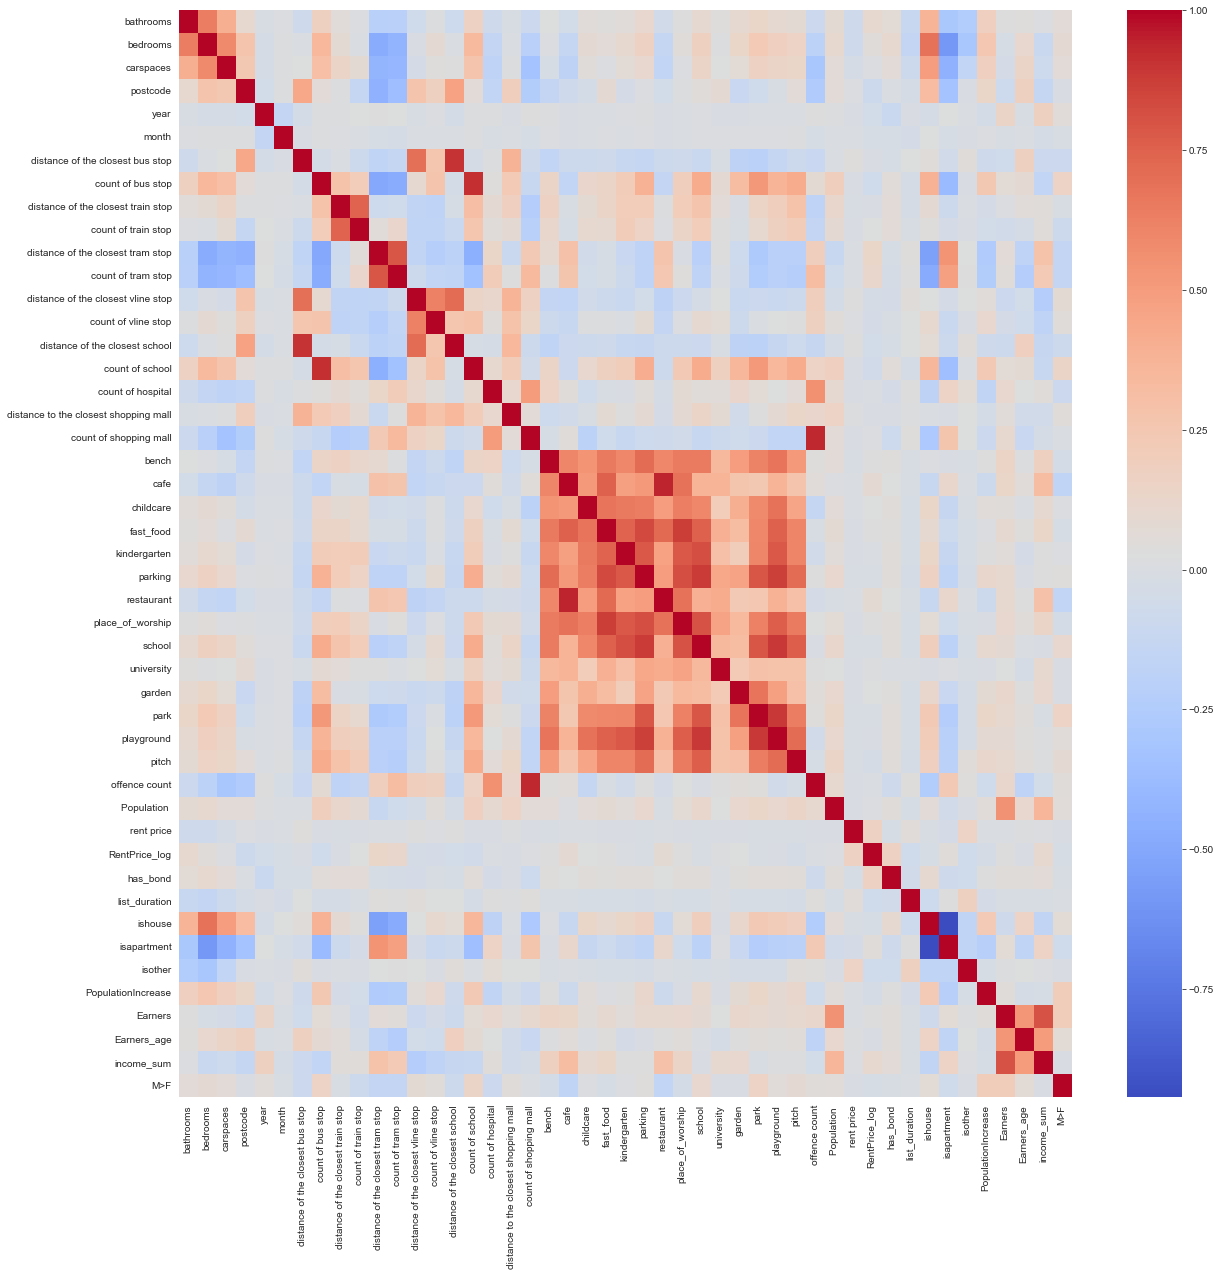

In [33]:
# Lets explore the correlations in our data set 
plt.figure(figsize=(20,20))
sns.heatmap(newdf.corr(), cmap="coolwarm")

In [34]:
# Fill diagonal and upper half with NaNs
corr = newdf.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

,bathrooms,bedrooms,carspaces,postcode,year,month,distance of the closest bus stop,count of bus stop,distance of the closest train stop,count of train stop,distance of the closest tram stop,count of tram stop,distance of the closest vline stop,count of vline stop,distance of the closest school,count of school,count of hospital,distance to the closest shopping mall,count of shopping mall,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,offence count,Population,rent price,RentPrice_log,has_bond,list_duration,ishouse,isapartment,isother,PopulationIncrease,Earners,Earners_age,income_sum,M>F
bathrooms,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
bedrooms,0.64,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
carspaces,0.40,0.59,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
postcode,0.10,0.27,0.24,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
year,-0.01,-0.03,-0.03,-0.05,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
month,0.01,0.02,0.02,0.02,-0.14,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
distance of the closest bus stop,-0.07,-0.00,0.02,0.45,-0.04,-0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
count of bus stop,0.18,0.35,0.30,0.06,0.02,0.02,-0.05,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
distance of the closest train stop,0.05,0.08,0.14,0.02,0.01,0.01,0.00,0.29,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
count of train stop,0.01,0.01,0.08,-0.13,0.03,0.00,-0.09,0.21,0.74,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


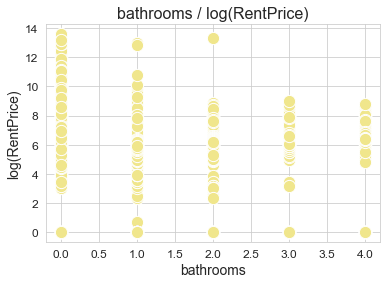

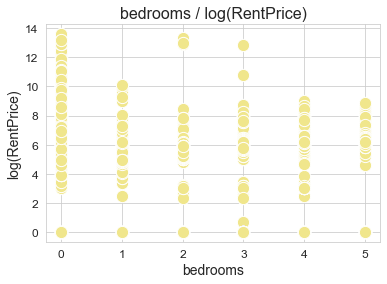

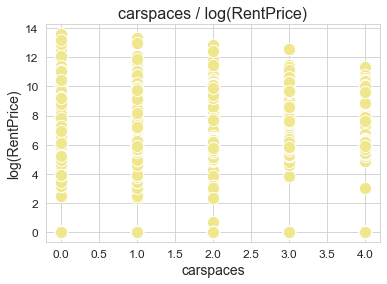

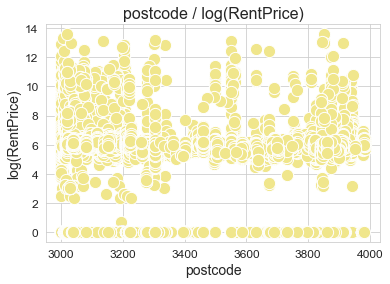

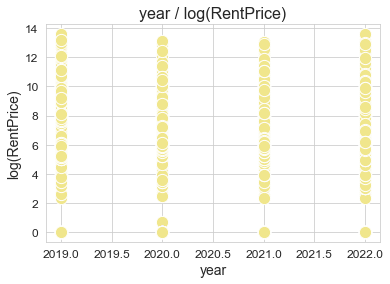

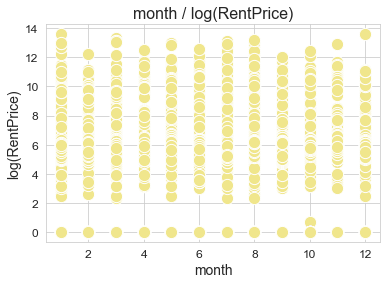

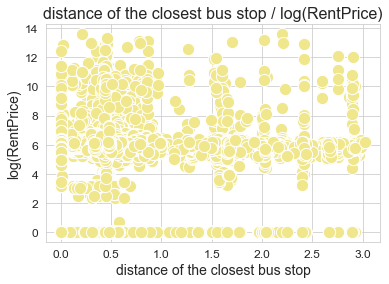

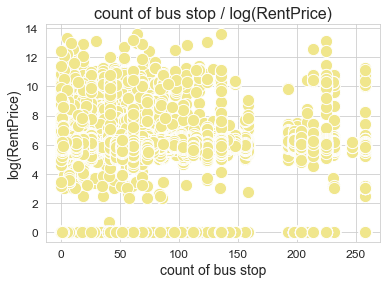

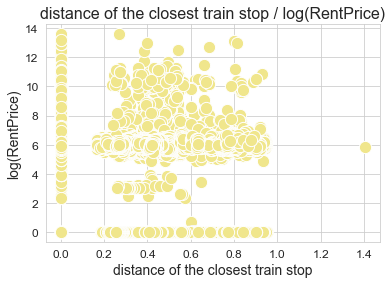

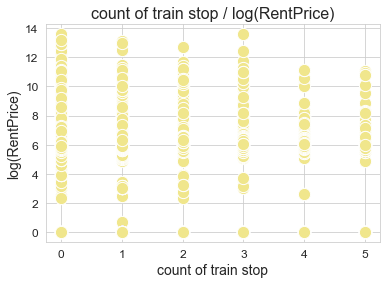

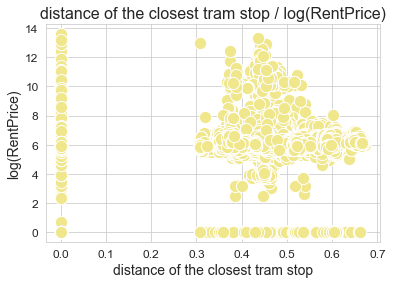

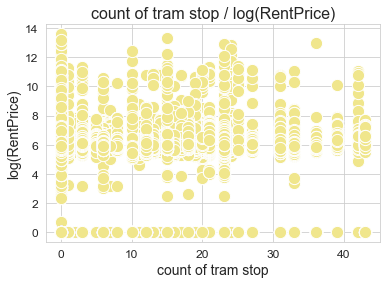

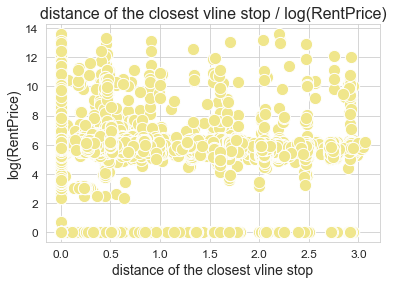

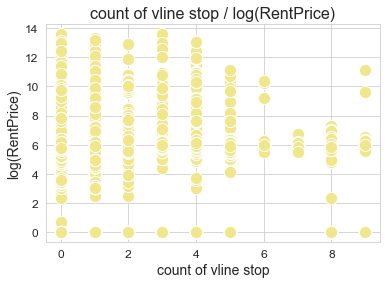

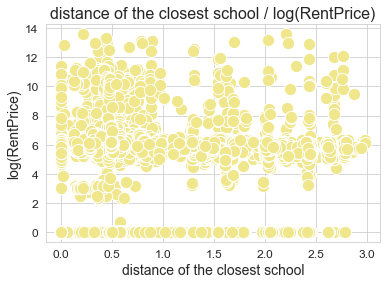

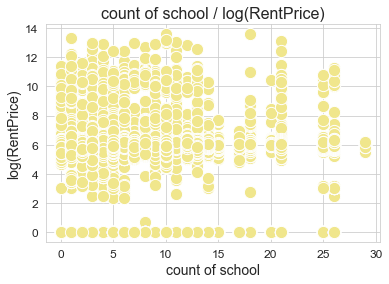

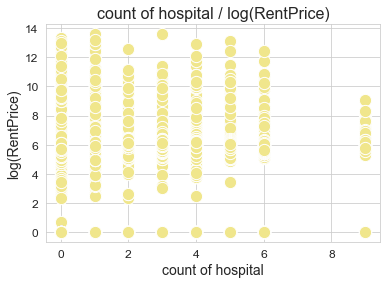

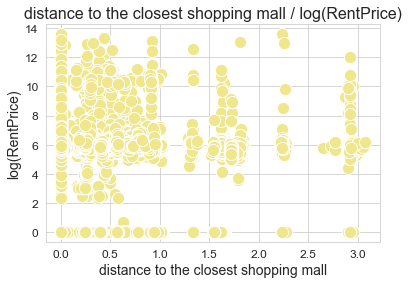

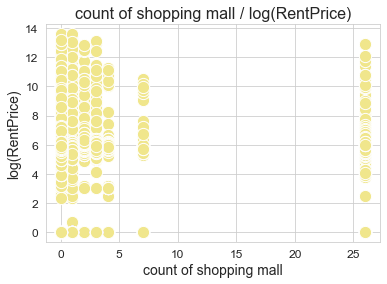

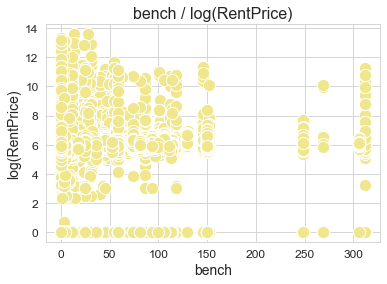

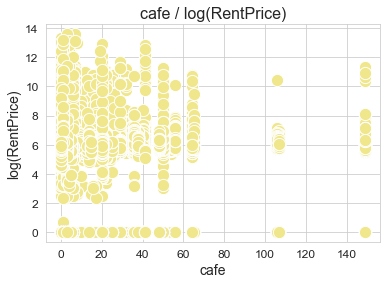

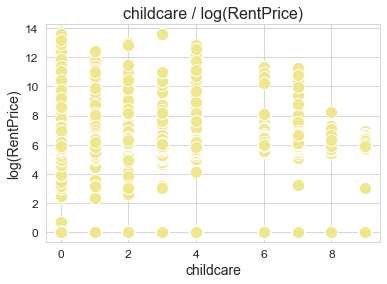

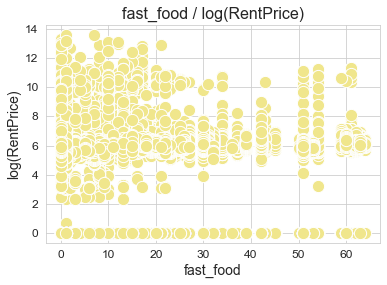

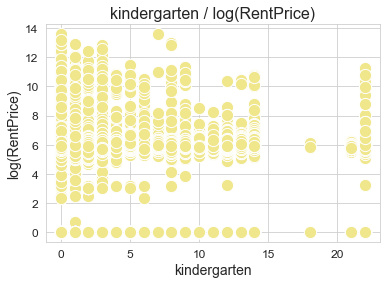

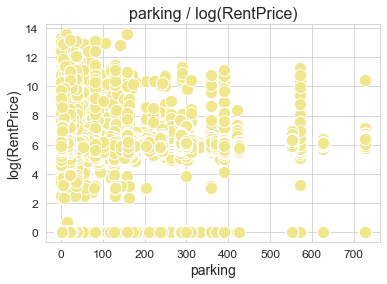

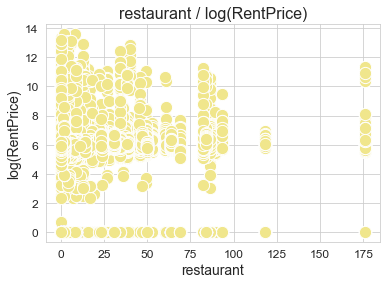

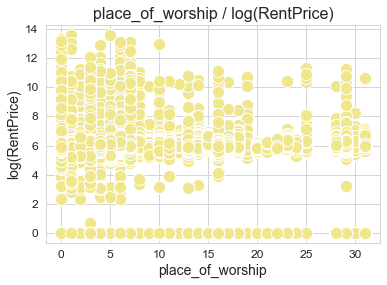

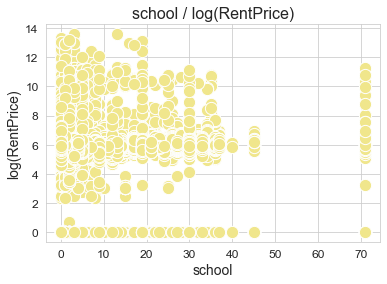

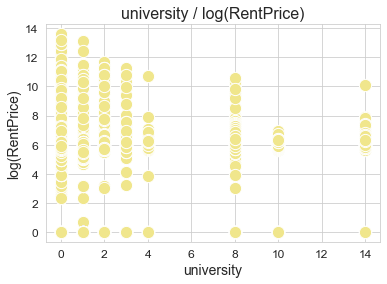

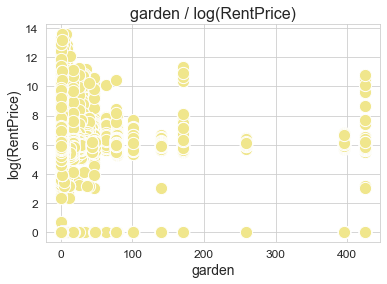

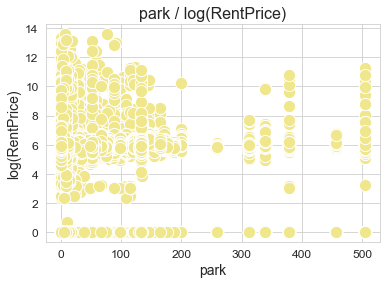

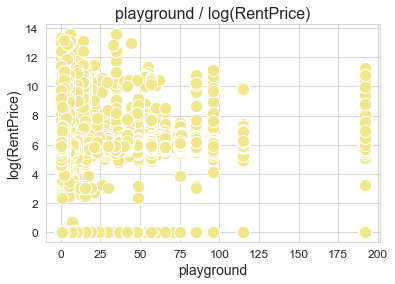

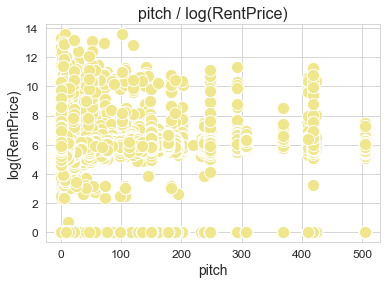

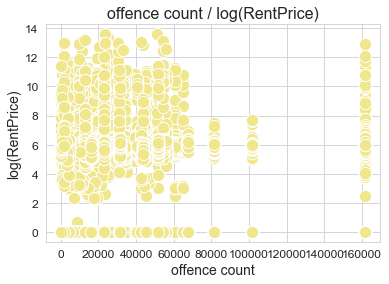

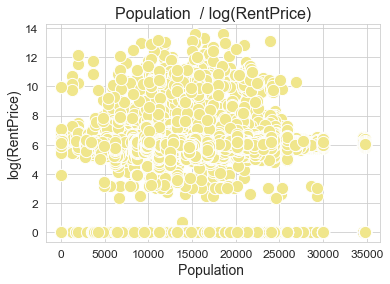

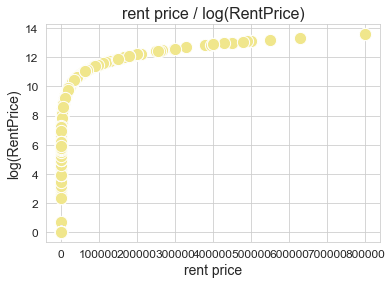

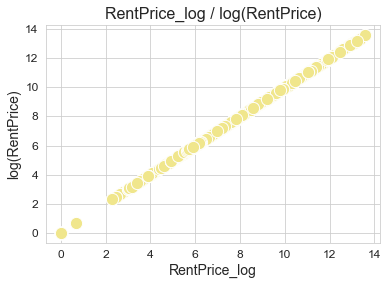

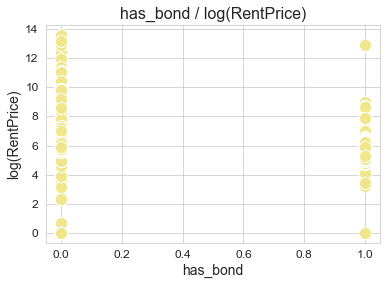

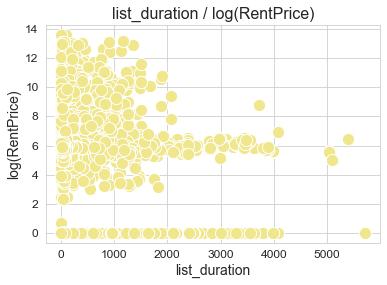

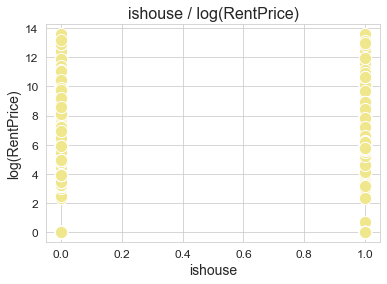

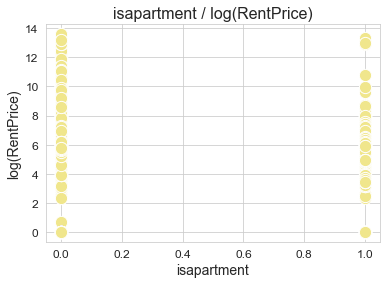

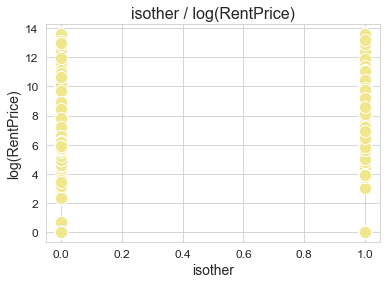

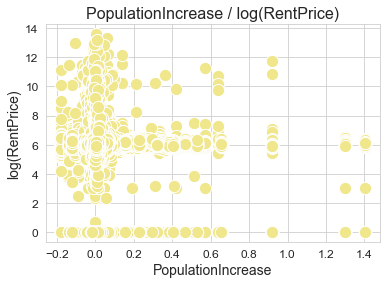

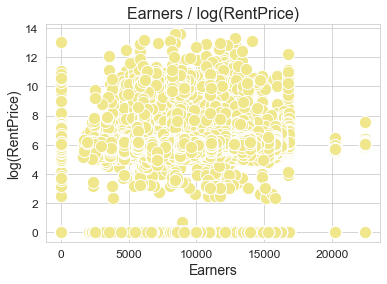

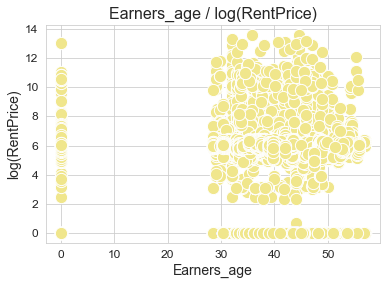

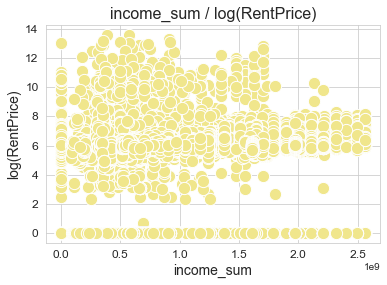

In [35]:
def scatter_df(y_var):
    scatter_df = newdf.drop(y_var, axis = 1)
    i = newdf.columns
    
    for m in range (0,len(scatter_df.columns)):
        plot1 = sns.scatterplot(x=i[m],y=y_var, data = newdf, color = 'khaki', s = 150)
        plt.title('{} / log(RentPrice)'.format(i[m]), fontsize = 16)
        plt.xlabel('{}'.format(i[m]), fontsize = 14)
        plt.ylabel('log(RentPrice)', fontsize = 14)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        # plt.savefig('scatter1.png')
        plt.show()
    
    
scatter_df('RentPrice_log')

## 4. Feature Selection 
Select features that are important to log(rent price).

### 4.1 f_regression
F-value between label/feature for regression tasks.

In [43]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# top 10
y = newdf['RentPrice_log']
X = newdf.drop(['RentPrice_log','rent price'], axis=1)
selector = SelectKBest(f_regression, k=10)
selector.fit(X, y)
X.columns[selector.get_support()]


Index(['bathrooms', 'postcode', 'count of bus stop',
       'distance of the closest tram stop', 'count of tram stop', 'cafe',
       'restaurant', 'has_bond', 'isother', 'income_sum'],
      dtype='object')

In [44]:
# top 20 
y = newdf['RentPrice_log']
X = newdf.drop(['RentPrice_log','rent price'], axis=1)
selector = SelectKBest(f_regression, k=20)
selector.fit(X, y)
needcolfv = X.columns[selector.get_support()]
needcolfv

Index(['bathrooms', 'bedrooms', 'postcode', 'year', 'count of bus stop',
       'distance of the closest tram stop', 'count of tram stop',
       'count of vline stop', 'distance of the closest school',
       'count of school', 'cafe', 'restaurant', 'place_of_worship', 'has_bond',
       'list_duration', 'isapartment', 'isother', 'PopulationIncrease',
       'Earners', 'income_sum'],
      dtype='object')

### 4.2 mutual_info_regression
Mutual information for a continuous target.

In [45]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

#Select top 10 features based on mutual info regression
selector = SelectKBest(mutual_info_regression, k =10)
selector.fit(X, y)
X.columns[selector.get_support()]


Index(['postcode', 'distance of the closest bus stop',
       'distance of the closest tram stop', 'distance of the closest school',
       'distance to the closest shopping mall', 'offence count', 'Population ',
       'PopulationIncrease', 'Earners', 'income_sum'],
      dtype='object')

In [46]:
#Select top 20 features based on mutual info regression
selector = SelectKBest(mutual_info_regression, k =20)
selector.fit(X, y)
needcolmi = X.columns[selector.get_support()]

In [47]:
## common features from both 
vals =  set(needcolfv).intersection(needcolmi)
vals

{'Earners',
 'PopulationIncrease',
 'bathrooms',
 'bedrooms',
 'count of bus stop',
 'distance of the closest school',
 'distance of the closest tram stop',
 'income_sum',
 'postcode'}

Notes:

Using different feature selection method, we can see that common features that are important to rental price are:
 - location 
 - transportation: bus, tram 
 - facilities: school, shopping mall 
 - security
 - population and income 

 Predictable factor: population and income 

 Metrix design should be around all above factors.